# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [2]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment3_starter" $datadir # TODO: Fill your A3 path
  datadir = "/content/drive/MyDrive/assignment3_starter"
os.chdir(datadir)
!pwd

/content/drive/.shortcut-targets-by-id/1C6vzFdqC8Hjc1SzmCGHlAtkpvu5roImn/assignment3_starter


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1 or 2 or 3: # 90, 180 or 270 degrees rotation counter-clockwise
        return transforms.functional.rotate(img=img, angle=(rot*90))
    # End TODO
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

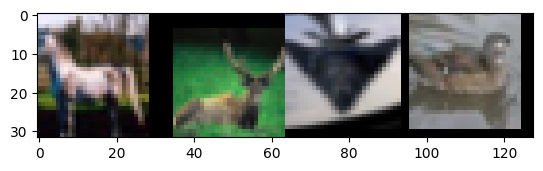

Class labels:  horse deer  plane bird 


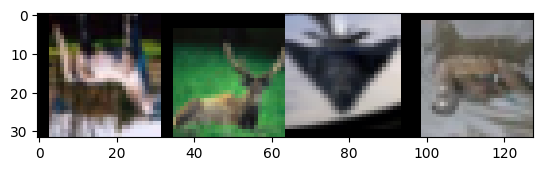

Rotation labels:  180   0     0     180  


In [6]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [7]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predictions = outputs.squeeze(0).softmax(1).argmax(dim=1)
            batch_correct = torch.sum(predictions == labels)
            correct += batch_correct
            total += predictions.shape[0]
            # End TODO

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [8]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a resnet50 on the rotation task

In this section, we will train a resnet50 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

net = resnet50(num_classes=4)
net = net.to(device)

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01) 
# Which to choose?? Are we free to choose what we like?

# TODO: Define criterion and optimizer


In [12]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation': 
                images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError('Task should either be classification or rotation')

            # TODO: Zero the parameter gradients
            net.zero_grad()

            # TODO: forward + backward + optimize
            outputs = net(images) # forward
            loss = criterion(outputs, labels) # loss calc
            loss.backward() # backward pass
            optimizer.step() # optimize

            # TODO: Get predicted results
            predicted = outputs.squeeze(0).softmax(1).argmax(dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)
        # ENd of TODO

    print('Finished Training')

In [14]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=5, init_lr=0.05, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), '/content/drive/MyDrive/assignment3_starter/resnet50_weights')

[1,   100] loss: 3.921 acc: 29.80 time: 11.60
[1,   200] loss: 4.087 acc: 25.09 time: 9.29
[1,   300] loss: 2.254 acc: 25.98 time: 10.98
TESTING:
Accuracy of the network on the 10000 test images: 28.26 %
Average loss on the 10000 test images: 1.579
[2,   100] loss: 1.479 acc: 27.06 time: 11.08
[2,   200] loss: 1.468 acc: 28.63 time: 10.36
[2,   300] loss: 1.419 acc: 30.71 time: 10.04
TESTING:
Accuracy of the network on the 10000 test images: 33.79 %
Average loss on the 10000 test images: 1.378
[3,   100] loss: 1.389 acc: 31.80 time: 11.32
[3,   200] loss: 1.384 acc: 31.87 time: 10.99
[3,   300] loss: 1.375 acc: 32.75 time: 9.38
TESTING:
Accuracy of the network on the 10000 test images: 33.69 %
Average loss on the 10000 test images: 1.404
[4,   100] loss: 1.358 acc: 32.98 time: 10.97
[4,   200] loss: 1.353 acc: 33.05 time: 11.09
[4,   300] loss: 1.350 acc: 34.16 time: 11.11
TESTING:
Accuracy of the network on the 10000 test images: 36.08 %
Average loss on the 10000 test images: 1.411
[5

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained resnet50 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

# TODO: Load the pre-trained resnet50 model
saved_state_dict = torch.load('/content/drive/MyDrive/assignment3_starter/resnet50_weights')
loaded_net = resnet50(num_classes=4)
loaded_net.load_state_dict(saved_state_dict)
loaded_net = loaded_net.to(device)
criterion = nn.CrossEntropyLoss()
run_test(loaded_net, testloader, criterion, 'rotation') # Verification, should give ~78% accuracy
# we also need to change no of outputs for the image label classification task
# to do this, reference : https://discuss.pytorch.org/t/how-to-reshape-last-layer-of-pytorch-cnn-model-while-doing-transfer-learning/62681/2 
old_input_features = loaded_net.fc.in_features
loaded_net.fc = nn.Linear(old_input_features, 10)
loaded_net = loaded_net.to(device)  # this is necessary after replacing the fc layer

TESTING:
Accuracy of the network on the 10000 test images: 74.88 %
Average loss on the 10000 test images: 0.637


In [ ]:
#run_test(net, testloader, criterion, 'rotation')
run_test(loaded_net, testloader, criterion, 'classification')  # should be close to random (10%) since model hasn't been trained on CIFAR-10 labels yet
#run_test(net, testloader, criterion, 'classification')

TESTING:
Accuracy of the network on the 10000 test images: 8.31 %
Average loss on the 10000 test images: 2.303


In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for param in loaded_net.parameters():
    param.requires_grad = False
for param in loaded_net.layer4.parameters():
    param.requires_grad = True
for param in loaded_net.fc.parameters():
    param.requires_grad = True

In [ ]:
print(type(loaded_net))
print(type(loaded_net.parameters))
print(type(loaded_net.layer4))
print(type(loaded_net.fc))
# print(type(loaded_net.features))
print(type(loaded_net.layer4.parameters))
print(type(loaded_net.fc.parameters))
# print(type(loaded_net.features.parameters))
#print(loaded_net)

<class 'torchvision.models.resnet.ResNet'>
<class 'method'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.linear.Linear'>
<class 'method'>
<class 'method'>


In [ ]:
# Print all the trainable parameters (they should be parameters of the last 2 layers)
params_to_update = loaded_net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in loaded_net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.conv3.weight
	 layer4.0.bn3.weight
	 layer4.0.bn3.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.1.conv3.weight
	 layer4.1.bn3.weight
	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr = 0.01) 

In [ ]:
train(loaded_net, criterion, optimizer, num_epochs=20, decay_epochs=9, init_lr=0.01, task='classification')
torch.save(loaded_net.state_dict(), '/content/drive/MyDrive/assignment3_starter/pretrained_resnet50_last_two_layers_fine_tuned_weights')

[1,   100] loss: 1.971 acc: 25.88 time: 9.50
[1,   200] loss: 1.709 acc: 36.65 time: 9.19
[1,   300] loss: 1.639 acc: 39.28 time: 7.96
TESTING:
Accuracy of the network on the 10000 test images: 43.03 %
Average loss on the 10000 test images: 1.602
[2,   100] loss: 1.561 acc: 42.95 time: 9.70
[2,   200] loss: 1.567 acc: 42.82 time: 8.16
[2,   300] loss: 1.516 acc: 45.43 time: 9.30
TESTING:
Accuracy of the network on the 10000 test images: 45.06 %
Average loss on the 10000 test images: 1.521
[3,   100] loss: 1.507 acc: 45.15 time: 9.66
[3,   200] loss: 1.488 acc: 45.49 time: 7.75
[3,   300] loss: 1.493 acc: 45.65 time: 9.67
TESTING:
Accuracy of the network on the 10000 test images: 47.28 %
Average loss on the 10000 test images: 1.477
[4,   100] loss: 1.467 acc: 47.14 time: 8.30
[4,   200] loss: 1.453 acc: 46.88 time: 9.37
[4,   300] loss: 1.451 acc: 46.80 time: 9.64
TESTING:
Accuracy of the network on the 10000 test images: 46.28 %
Average loss on the 10000 test images: 1.489
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a resnet50 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

# TODO: Randomly initialize a resnet50 model
r_init_net = resnet50(num_classes=10).to(device)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for param in r_init_net.parameters():
    param.requires_grad = False
for param in r_init_net.layer4.parameters():
    param.requires_grad = True
for param in r_init_net.fc.parameters():
    param.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = r_init_net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in r_init_net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr = 0.01)

In [ ]:
train(r_init_net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(r_init_net.state_dict(), '/content/drive/MyDrive/assignment3_starter/random_init_resnet50_last_two_layers_fine_tuned_weights')

[1,   100] loss: 4.038 acc: 13.95 time: 8.17
[1,   200] loss: 2.681 acc: 17.08 time: 8.91
[1,   300] loss: 2.248 acc: 17.42 time: 9.06
TESTING:
Accuracy of the network on the 10000 test images: 20.22 %
Average loss on the 10000 test images: 2.136
[2,   100] loss: 2.162 acc: 19.41 time: 10.12
[2,   200] loss: 2.135 acc: 20.34 time: 9.24
[2,   300] loss: 2.138 acc: 20.57 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 21.78 %
Average loss on the 10000 test images: 2.092
[3,   100] loss: 2.121 acc: 21.05 time: 9.49
[3,   200] loss: 2.116 acc: 21.16 time: 8.66
[3,   300] loss: 2.101 acc: 22.20 time: 8.03
TESTING:
Accuracy of the network on the 10000 test images: 23.19 %
Average loss on the 10000 test images: 2.055
[4,   100] loss: 2.096 acc: 21.82 time: 9.23
[4,   200] loss: 2.093 acc: 21.61 time: 7.54
[4,   300] loss: 2.088 acc: 22.38 time: 9.03
TESTING:
Accuracy of the network on the 10000 test images: 23.93 %
Average loss on the 10000 test images: 2.048
[5,   100] 

##Supervised training on the pre-trained model
In this section, we will load the pre-trained resnet50 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

# TODO: Load the pre-trained resnet50 model
saved_state_dict = torch.load('/content/drive/MyDrive/assignment3_starter/resnet50_weights')
loaded_net2 = resnet50(num_classes=4)
loaded_net2.load_state_dict(saved_state_dict)
loaded_net2 = loaded_net2.to(device)
run_test(loaded_net2, testloader, criterion, 'rotation')  # Verification, should give ~78% accuracy
# we also need to change no of outputs for the image label classification task
# to do this, reference : https://discuss.pytorch.org/t/how-to-reshape-last-layer-of-pytorch-cnn-model-while-doing-transfer-learning/62681/2 
old_input_features = loaded_net2.fc.in_features
loaded_net2.fc = nn.Linear(old_input_features, 10)
loaded_net2 = loaded_net2.to(device) # this is necessary after replacing the fc layer

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(loaded_net2.parameters(), lr = 0.01)

In [ ]:
train(loaded_net2, criterion, optimizer, num_epochs=20, decay_epochs=9, init_lr=0.01, task='classification')
torch.save(loaded_net2.state_dict(), '/content/drive/MyDrive/assignment3_starter/pretrained_resnet50_all_layers_fine_tuned_weights')

[1,   100] loss: 0.433 acc: 84.95 time: 11.12
[1,   200] loss: 0.427 acc: 84.88 time: 10.87
[1,   300] loss: 0.429 acc: 85.21 time: 9.46
TESTING:
Accuracy of the network on the 10000 test images: 82.86 %
Average loss on the 10000 test images: 0.507
[2,   100] loss: 0.443 acc: 84.85 time: 10.68
[2,   200] loss: 0.441 acc: 84.65 time: 10.39
[2,   300] loss: 0.421 acc: 85.36 time: 8.96
TESTING:
Accuracy of the network on the 10000 test images: 82.69 %
Average loss on the 10000 test images: 0.506
[3,   100] loss: 0.435 acc: 84.93 time: 10.87
[3,   200] loss: 0.434 acc: 85.03 time: 10.51
[3,   300] loss: 0.438 acc: 84.87 time: 9.44
TESTING:
Accuracy of the network on the 10000 test images: 82.58 %
Average loss on the 10000 test images: 0.509
[4,   100] loss: 0.437 acc: 84.65 time: 10.15
[4,   200] loss: 0.439 acc: 84.71 time: 10.50
[4,   300] loss: 0.429 acc: 85.02 time: 10.45
TESTING:
Accuracy of the network on the 10000 test images: 82.79 %
Average loss on the 10000 test images: 0.505
[5,

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a resnet50 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

# TODO: Randomly initialize a resnet50 model
r_init_net2 = resnet50(num_classes = 10).to(device)

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(r_init_net2.parameters(), lr = 0.01)

In [ ]:
train(r_init_net2, criterion, optimizer, num_epochs=20, decay_epochs=9, init_lr=0.01, task='classification')
torch.save(r_init_net2.state_dict(), '/content/drive/MyDrive/assignment3_starter/random_init_resnet50_all_layers_fine_tuned_weights')

[1,   100] loss: 0.992 acc: 65.91 time: 15.14
[1,   200] loss: 1.026 acc: 65.18 time: 14.26
[1,   300] loss: 0.996 acc: 65.52 time: 9.08
TESTING:
Accuracy of the network on the 10000 test images: 67.93 %
Average loss on the 10000 test images: 1.514
[2,   100] loss: 0.907 acc: 68.88 time: 10.73
[2,   200] loss: 0.837 acc: 71.07 time: 10.25
[2,   300] loss: 0.861 acc: 70.40 time: 8.66
TESTING:
Accuracy of the network on the 10000 test images: 44.76 %
Average loss on the 10000 test images: 283.216
[3,   100] loss: 0.923 acc: 67.85 time: 10.66
[3,   200] loss: 0.833 acc: 71.05 time: 11.48
[3,   300] loss: 0.829 acc: 71.36 time: 9.27
TESTING:
Accuracy of the network on the 10000 test images: 72.71 %
Average loss on the 10000 test images: 0.890
[4,   100] loss: 0.773 acc: 73.43 time: 10.28
[4,   200] loss: 0.853 acc: 70.77 time: 10.34
[4,   300] loss: 0.814 acc: 71.83 time: 9.65
TESTING:
Accuracy of the network on the 10000 test images: 69.38 %
Average loss on the 10000 test images: 0.916
[5